# Benchmark Data Analysis Notebook

This notebook loads benchmark results, merges CSV files from different platforms, and generates various plots for analysis.

In [55]:
#!/usr/bin/env python3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams["font.size"] = 20
plt.rcParams["axes.titlesize"] = 24
plt.rcParams["axes.labelsize"] = 20
plt.rcParams["xtick.labelsize"] = 18
plt.rcParams["ytick.labelsize"] = 18
plt.rcParams["legend.fontsize"] = 16

COLORS = {
    "macOS": "#FF6B6B",
    "WSL": "#4ECDC4",
    "Linux": "#45B7D1",
    "XOR": "#FF6B6B",
    "AES-256-CTR": "#4ECDC4",
    "Sequential": "#636EFA",
    "OpenMP": "#EF553B",
    "OpenCL": "#00CC96",
    "Metal": "#AB63FA",
    "CUDA": "#FFA15A",
}

## Merge CSV Files (Optional)

If you have separate result files, run this cell to merge them into combined_results.csv.

In [56]:
import csv
import os

def merge_csvs(file1, file2, output_file):
    headers = []
    rows = []
    if os.path.exists(file1):
        with open(file1, 'r', newline='') as f:
            reader = csv.reader(f)
            headers = next(reader)
            rows.extend(list(reader))
    if os.path.exists(file2):
        with open(file2, 'r', newline='') as f:
            reader = csv.reader(f)
            file2_headers = next(reader)
            if file2_headers == headers:
                rows.extend(list(reader))
            else:
                print(f"Warning: Headers in {file2} do not match {file1}. Skipping.")
    with open(output_file, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(headers)
        writer.writerows(rows)
    print(f"Successfully merged {len(rows)} rows into {output_file}")

macos_file = "../results/macos_results.csv"
wsl_file = "../build/results.csv"
output_file = "../results/combined_results.csv"

merge_csvs(macos_file, wsl_file, output_file)

Successfully merged 42 rows into ../results/combined_results.csv


## Load Data from Results Directory

Load the combined results CSV file for analysis.

In [57]:
csv_path = "../results/combined_results.csv"
if not os.path.exists(csv_path):
    results_dir = "../results"
    if os.path.exists(results_dir):
        csv_files = [f for f in os.listdir(results_dir) if f.endswith('.csv')]
        if csv_files:
            csv_path = os.path.join(results_dir, csv_files[0])

if os.path.exists(csv_path):
    df = pd.read_csv(csv_path)
    print(f"Loaded data from: {csv_path}")
    print(f"Data shape: {df.shape}")
else:
    print("No data loaded.")

Loaded data from: ../results/combined_results.csv
Data shape: (42, 13)


## Define Plotting Functions

These functions generate various charts from the data.

In [58]:
def plot_throughput_vs_filesize(df, output_dir):
    """Generate separate throughput vs filesize plots for each algorithm"""
    for algo in ["XOR", "AES-256-CTR"]:
        fig, ax = plt.subplots(figsize=(10, 7))
        algo_data = df[df["Algorithm"] == algo]

        for platform in algo_data["Platform"].unique():
            for engine in algo_data["Engine"].unique():
                subset = algo_data[
                    (algo_data["Platform"] == platform)
                    & (algo_data["Engine"] == engine)
                ]
                if len(subset) > 0:
                    best_per_size = subset.groupby("FileSize_MB")[
                        "Throughput_MBs"
                    ].max()
                    label = f"{platform} - {engine}"
                    ax.plot(
                        best_per_size.index,
                        best_per_size.values,
                        "o-",
                        label=label,
                        linewidth=2.5,
                        markersize=10,
                    )

        ax.set_xlabel("File Size [MB]")
        ax.set_ylabel("Throughput [MB/s]")
        ax.set_title(f"{algo} - Throughput vs File Size")
        ax.legend(loc="best")
        ax.grid(True, alpha=0.3)
        ax.set_xscale("log")

        plt.tight_layout()
        filename = f"throughput_vs_filesize_{algo.lower().replace('-', '_')}.png"
        plt.savefig(os.path.join(output_dir, filename), dpi=150, bbox_inches="tight")
        plt.show()
        plt.close()
        print(f"Saved: {filename}")


def plot_execution_time_comparison(df, output_dir):
    """Generate separate execution time plots for each algorithm"""
    platforms = df["Platform"].unique()
    engines = df["Engine"].unique()
    algorithms = df["Algorithm"].unique()

    for algo in algorithms:
        fig, ax = plt.subplots(figsize=(10, 7))
        algo_data = df[df["Algorithm"] == algo]

        x = np.arange(len(engines))
        width = 0.35

        for i, platform in enumerate(platforms):
            platform_data = algo_data[algo_data["Platform"] == platform]
            times = []
            for engine in engines:
                engine_data = platform_data[platform_data["Engine"] == engine]
                if len(engine_data) > 0:
                    times.append(engine_data["Time_Sec"].min() * 1000)
                else:
                    times.append(0)

            color = COLORS.get(platform, "#888888")
            ax.bar(x + i * width - width / 2, times, width, label=platform, color=color)

        ax.set_xlabel("Engine")
        ax.set_ylabel("Execution Time [ms]")
        ax.set_title(f"{algo} - Execution Time per Method")
        ax.set_xticks(x)
        ax.set_xticklabels(engines, rotation=45, ha="right")
        ax.legend()
        ax.grid(True, alpha=0.3, axis="y")

        for container in ax.containers:
            ax.bar_label(container, fmt="%.1f", fontsize=11, rotation=90, padding=3)

        plt.tight_layout()
        filename = f"execution_time_{algo.lower().replace('-', '_')}.png"
        plt.savefig(os.path.join(output_dir, filename), dpi=150, bbox_inches="tight")
        plt.show()
        plt.close()
        print(f"Saved: {filename}")


def plot_max_throughput_per_method(df, output_dir):
    """Generate separate max throughput plots for each algorithm"""
    for algo in ["XOR", "AES-256-CTR"]:
        fig, ax = plt.subplots(figsize=(10, 7))
        algo_data = df[df["Algorithm"] == algo]

        max_throughput = (
            algo_data.groupby(["Platform", "Engine"])["Throughput_MBs"]
            .max()
            .unstack(fill_value=0)
        )

        max_throughput.plot(kind="bar", ax=ax, colormap="viridis", width=0.8)

        ax.set_xlabel("Platform")
        ax.set_ylabel("Maximum Throughput [MB/s]")
        ax.set_title(f"{algo} - Maximum Throughput per Method")
        ax.legend(title="Engine", loc="best")
        ax.grid(True, alpha=0.3, axis="y")
        ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

        for container in ax.containers:
            ax.bar_label(container, fmt="%.0f", fontsize=10, rotation=90, padding=3)

        plt.tight_layout()
        filename = f"max_throughput_{algo.lower().replace('-', '_')}.png"
        plt.savefig(os.path.join(output_dir, filename), dpi=150, bbox_inches="tight")
        plt.show()
        plt.close()
        print(f"Saved: {filename}")


def plot_energy_consumption(df, output_dir):
    """Generate separate energy consumption plots for each algorithm"""
    df_copy = df.copy()
    df_copy["Energy_per_MB"] = df_copy["Energy_Joules"] / df_copy["FileSize_MB"]

    for algo in ["XOR", "AES-256-CTR"]:
        fig, ax = plt.subplots(figsize=(10, 7))
        algo_data = df_copy[df_copy["Algorithm"] == algo]

        energy_data = (
            algo_data.groupby(["Platform", "Engine"])["Energy_per_MB"]
            .mean()
            .unstack(fill_value=0)
        )

        energy_data.plot(kind="bar", ax=ax, colormap="plasma", width=0.8)

        ax.set_xlabel("Platform")
        ax.set_ylabel("Energy per MB [J/MB]")
        ax.set_title(f"{algo} - Energy Consumption per Method")
        ax.legend(title="Engine", loc="best")
        ax.grid(True, alpha=0.3, axis="y")
        ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

        for container in ax.containers:
            ax.bar_label(container, fmt="%.2f", fontsize=10, rotation=90, padding=3)

        plt.tight_layout()
        filename = f"energy_consumption_{algo.lower().replace('-', '_')}.png"
        plt.savefig(os.path.join(output_dir, filename), dpi=150, bbox_inches="tight")
        plt.show()
        plt.close()
        print(f"Saved: {filename}")


def plot_xor_vs_aes(df, output_dir):
    """Generate XOR vs AES comparison plot"""
    fig, ax = plt.subplots(figsize=(10, 7))

    best_results = df.loc[
        df.groupby(["Platform", "Algorithm", "Engine"])["Throughput_MBs"].idxmax()
    ]

    platforms = best_results["Platform"].unique()
    algorithms = ["XOR", "AES-256-CTR"]

    x = np.arange(len(platforms))
    width = 0.35

    for i, algo in enumerate(algorithms):
        algo_data = best_results[best_results["Algorithm"] == algo]
        throughputs = []
        for platform in platforms:
            platform_data = algo_data[algo_data["Platform"] == platform]
            if len(platform_data) > 0:
                throughputs.append(platform_data["Throughput_MBs"].max())
            else:
                throughputs.append(0)

        color = COLORS.get(algo, "#888888")
        bars = ax.bar(
            x + i * width - width / 2, throughputs, width, label=algo, color=color
        )

        for bar, val in zip(bars, throughputs):
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height() + 500,
                f"{val:.0f}",
                ha="center",
                va="bottom",
                fontsize=12,
            )

    ax.set_xlabel("Platform")
    ax.set_ylabel("Maximum Throughput [MB/s]")
    ax.set_title("XOR vs AES-256-CTR - Best Performance by Platform")
    ax.set_xticks(x)
    ax.set_xticklabels(platforms)
    ax.legend()
    ax.grid(True, alpha=0.3, axis="y")

    plt.tight_layout()
    plt.savefig(
        os.path.join(output_dir, "xor_vs_aes_comparison.png"),
        dpi=150,
        bbox_inches="tight",
    )
    plt.show()
    plt.close()
    print("Saved: xor_vs_aes_comparison.png")


def plot_speedup_efficiency(df, output_dir):
    """Generate separate speedup and efficiency plots for each algorithm"""
    openmp_data = df[df["Engine"] == "OpenMP"]

    if len(openmp_data) == 0 or openmp_data["NumThreads"].nunique() <= 1:
        print("Skipping speedup/efficiency charts - no thread scaling data")
        return

    for algo in ["XOR", "AES-256-CTR"]:
        algo_data = openmp_data[openmp_data["Algorithm"] == algo]
        
        # Speedup plot
        fig, ax = plt.subplots(figsize=(10, 7))
        for platform in algo_data["Platform"].unique():
            platform_data = algo_data[algo_data["Platform"] == platform]
            for file_size in platform_data["FileSize_MB"].unique():
                size_data = platform_data[
                    platform_data["FileSize_MB"] == file_size
                ].sort_values("NumThreads")
                if len(size_data) > 1:
                    label = f"{platform} {file_size}MB"
                    ax.plot(
                        size_data["NumThreads"],
                        size_data["Speedup"],
                        "o-",
                        label=label,
                        linewidth=2.5,
                        markersize=8,
                    )

        max_threads = openmp_data["NumThreads"].max()
        ax.plot([1, max_threads], [1, max_threads], "k--", alpha=0.5, label="Ideal")
        ax.set_xlabel("Number of Threads")
        ax.set_ylabel("Speedup")
        ax.set_title(f"{algo} - Speedup vs Threads (OpenMP)")
        ax.legend(loc="best")
        ax.grid(True, alpha=0.3)

        plt.tight_layout()
        filename = f"speedup_{algo.lower().replace('-', '_')}.png"
        plt.savefig(os.path.join(output_dir, filename), dpi=150, bbox_inches="tight")
        plt.show()
        plt.close()
        print(f"Saved: {filename}")

        # Efficiency plot
        fig, ax = plt.subplots(figsize=(10, 7))
        for platform in algo_data["Platform"].unique():
            platform_data = algo_data[algo_data["Platform"] == platform]
            for file_size in platform_data["FileSize_MB"].unique():
                size_data = platform_data[
                    platform_data["FileSize_MB"] == file_size
                ].sort_values("NumThreads")
                if len(size_data) > 1:
                    label = f"{platform} {file_size}MB"
                    ax.plot(
                        size_data["NumThreads"],
                        size_data["Efficiency"] * 100,
                        "o-",
                        label=label,
                        linewidth=2.5,
                        markersize=8,
                    )

        ax.axhline(y=100, color="k", linestyle="--", alpha=0.5, label="Ideal (100%)")
        ax.set_xlabel("Number of Threads")
        ax.set_ylabel("Efficiency [%]")
        ax.set_title(f"{algo} - Parallel Efficiency (OpenMP)")
        ax.legend(loc="best")
        ax.grid(True, alpha=0.3)
        ax.set_ylim(0, 120)

        plt.tight_layout()
        filename = f"efficiency_{algo.lower().replace('-', '_')}.png"
        plt.savefig(os.path.join(output_dir, filename), dpi=150, bbox_inches="tight")
        plt.show()
        plt.close()
        print(f"Saved: {filename}")


def print_summary(df):
    print("\n" + "=" * 70)
    print("BENCHMARK SUMMARY")
    print("=" * 70)

    print(f"\nPlatforms: {', '.join(df['Platform'].unique())}")
    print(f"Algorithms: {', '.join(df['Algorithm'].unique())}")
    print(f"Engines: {', '.join(df['Engine'].unique())}")
    print(f"File Sizes: {', '.join(map(str, sorted(df['FileSize_MB'].unique())))} MB")

    print("\n" + "-" * 70)
    print("VERIFICATION STATUS")
    print("-" * 70)
    total = len(df)
    passed = len(df[df["Verified"] == "PASS"])
    print(f"Total: {total} | Passed: {passed} ({100*passed/total:.1f}%)")

    print("\n" + "-" * 70)
    print("BEST RESULTS")
    print("-" * 70)

    for algo in df["Algorithm"].unique():
        algo_data = df[df["Algorithm"] == algo]
        best = algo_data.loc[algo_data["Throughput_MBs"].idxmax()]
        print(f"\n{algo}:")
        print(f"  Platform: {best['Platform']}, Engine: {best['Engine']}")
        print(f"  Throughput: {best['Throughput_MBs']:.2f} MB/s")
        print(f"  Time: {best['Time_Sec']*1000:.2f} ms")

    print("\n" + "=" * 70)

## Print Summary

Display a summary of the benchmark results.

In [59]:
if 'df' in locals():
    print_summary(df)
else:
    print("Data not loaded yet.")


BENCHMARK SUMMARY

Platforms: macOS
Algorithms: XOR, AES-256-CTR
Engines: Sequential, OpenMP, Metal
File Sizes: 1024, 5120, 10024 MB

----------------------------------------------------------------------
VERIFICATION STATUS
----------------------------------------------------------------------
Total: 42 | Passed: 42 (100.0%)

----------------------------------------------------------------------
BEST RESULTS
----------------------------------------------------------------------

XOR:
  Platform: macOS, Engine: OpenMP
  Throughput: 7782.27 MB/s
  Time: 131.58 ms

AES-256-CTR:
  Platform: macOS, Engine: OpenMP
  Throughput: 70901.31 MB/s
  Time: 14.44 ms



## Plot Throughput vs File Size

Generate plots showing throughput vs file size for each algorithm.

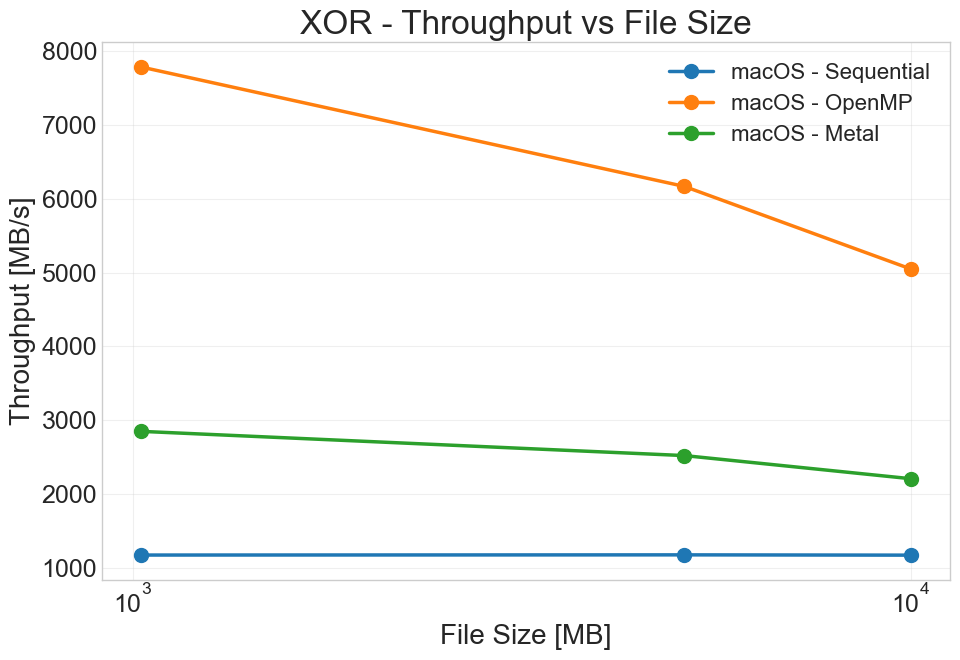

Saved: throughput_vs_filesize_xor.png


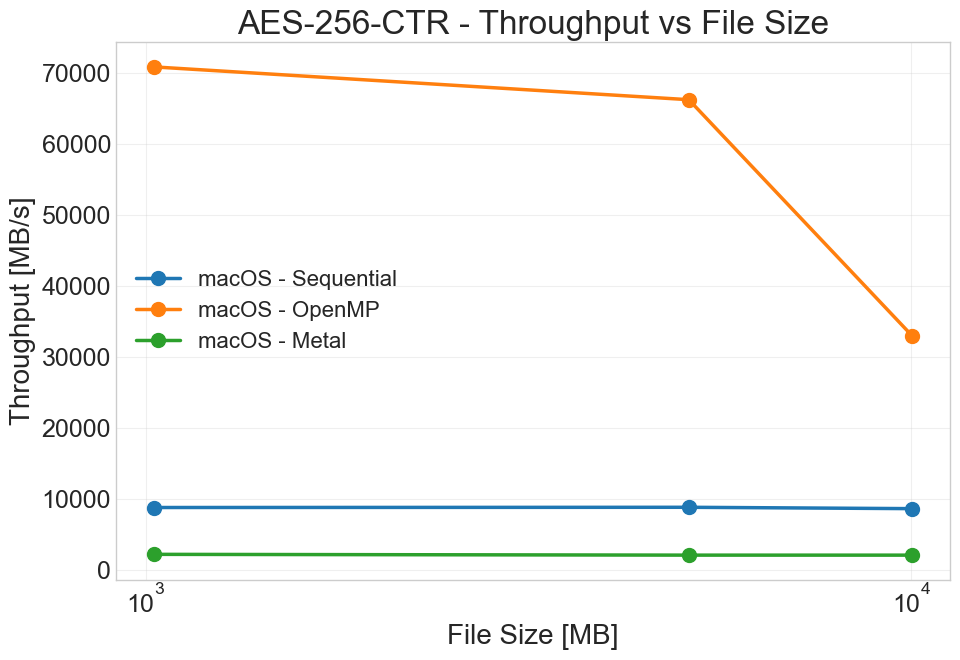

Saved: throughput_vs_filesize_aes_256_ctr.png


In [60]:
if 'df' in locals():
    output_dir = "../results/images"
    os.makedirs(output_dir, exist_ok=True)
    plot_throughput_vs_filesize(df, output_dir)

else:    print("Data not loaded.")

## Plot Execution Time Comparison

Compare execution times for different engines and platforms.

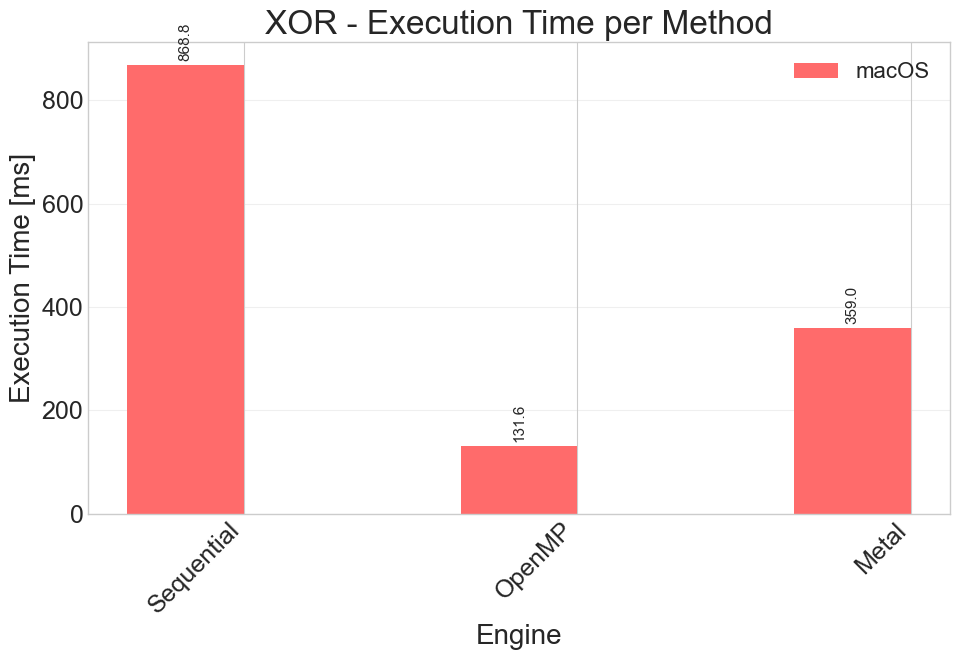

Saved: execution_time_xor.png


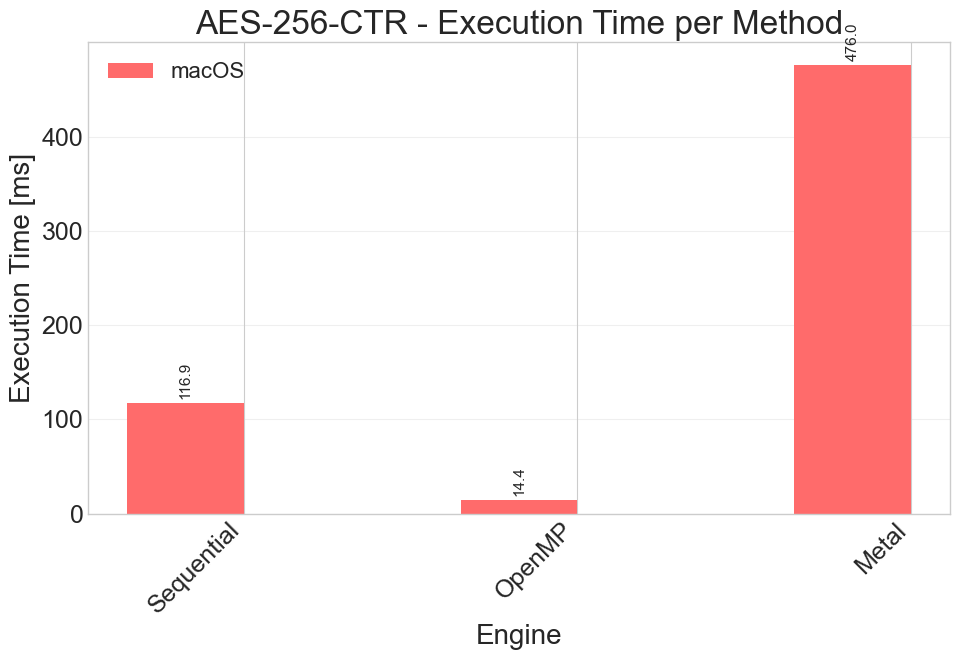

Saved: execution_time_aes_256_ctr.png


In [61]:
if 'df' in locals():
    output_dir = "../results/images"
    os.makedirs(output_dir, exist_ok=True)
    plot_execution_time_comparison(df, output_dir)

else:    print("Data not loaded.")

## Plot Maximum Throughput per Method

Show maximum throughput for each platform and engine.

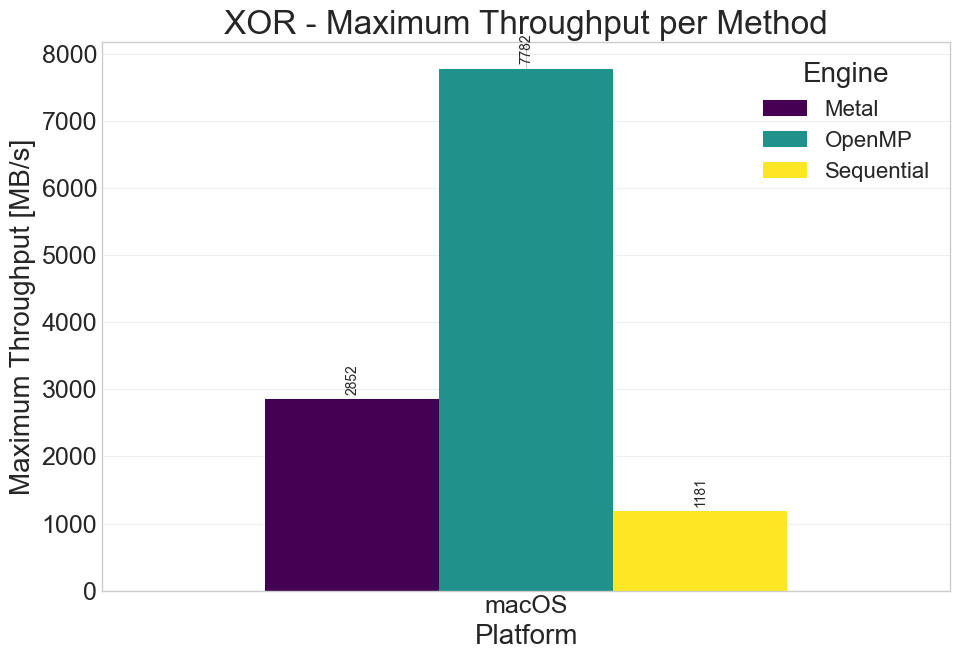

Saved: max_throughput_xor.png


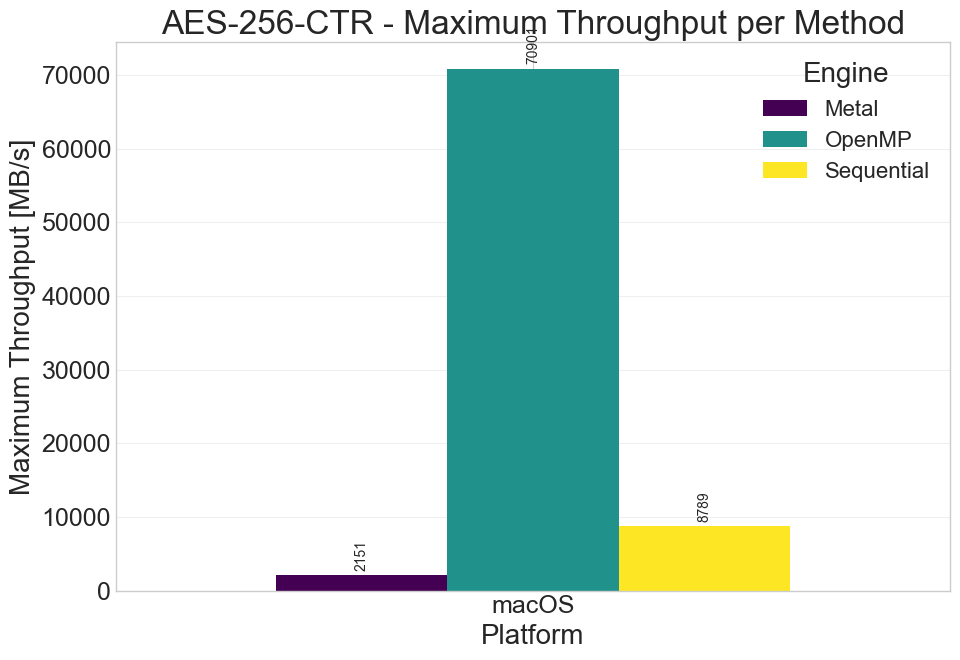

Saved: max_throughput_aes_256_ctr.png


In [62]:
if 'df' in locals():
    output_dir = "../results/images"
    os.makedirs(output_dir, exist_ok=True)
    plot_max_throughput_per_method(df, output_dir)

else:    print("Data not loaded.")

## Plot Energy Consumption

Analyze energy usage per MB for different methods.

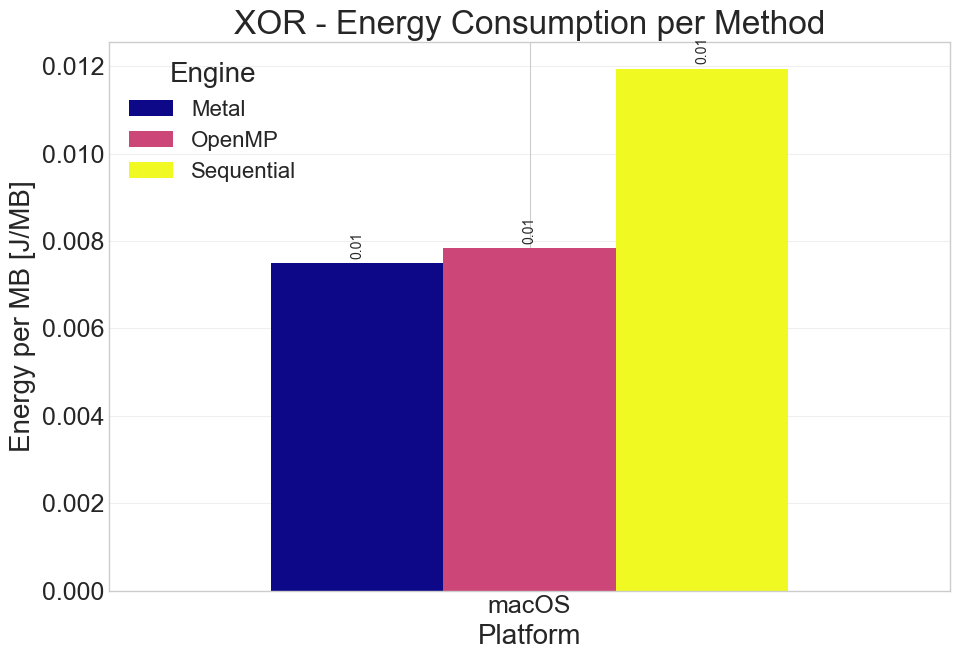

Saved: energy_consumption_xor.png


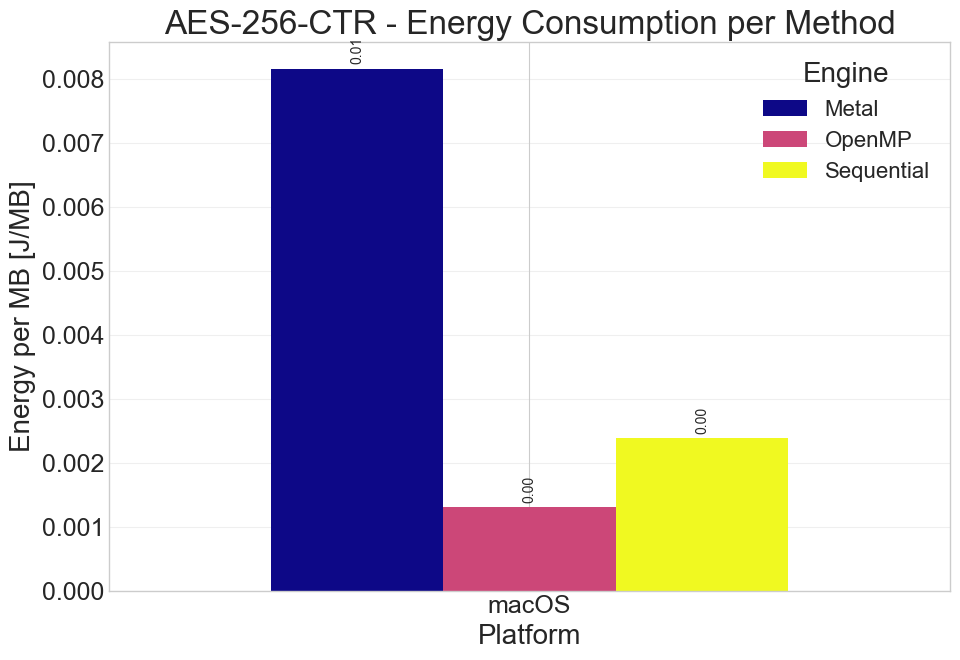

Saved: energy_consumption_aes_256_ctr.png


In [63]:
if 'df' in locals():
    output_dir = "../results/images"
    os.makedirs(output_dir, exist_ok=True)
    plot_energy_consumption(df, output_dir)

else:    print("Data not loaded.")

## Plot XOR vs AES Comparison

Compare best performances between XOR and AES algorithms.

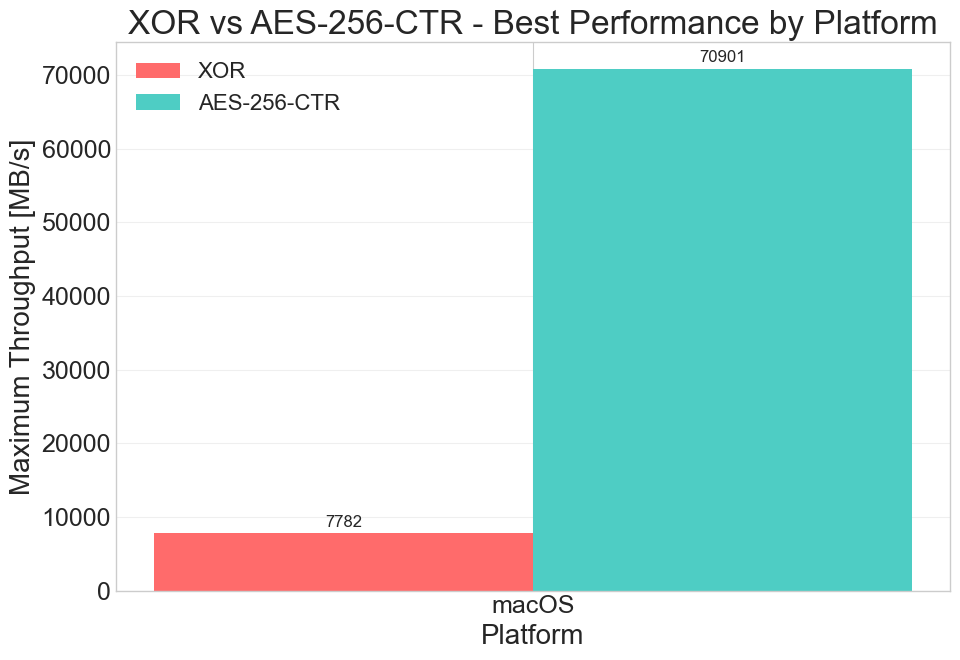

Saved: xor_vs_aes_comparison.png


In [64]:
if 'df' in locals():
    output_dir = "../results/images"
    os.makedirs(output_dir, exist_ok=True)
    plot_xor_vs_aes(df, output_dir)

else:    print("Data not loaded.")

## Plot Speedup and Efficiency

Analyze speedup and parallel efficiency for OpenMP.

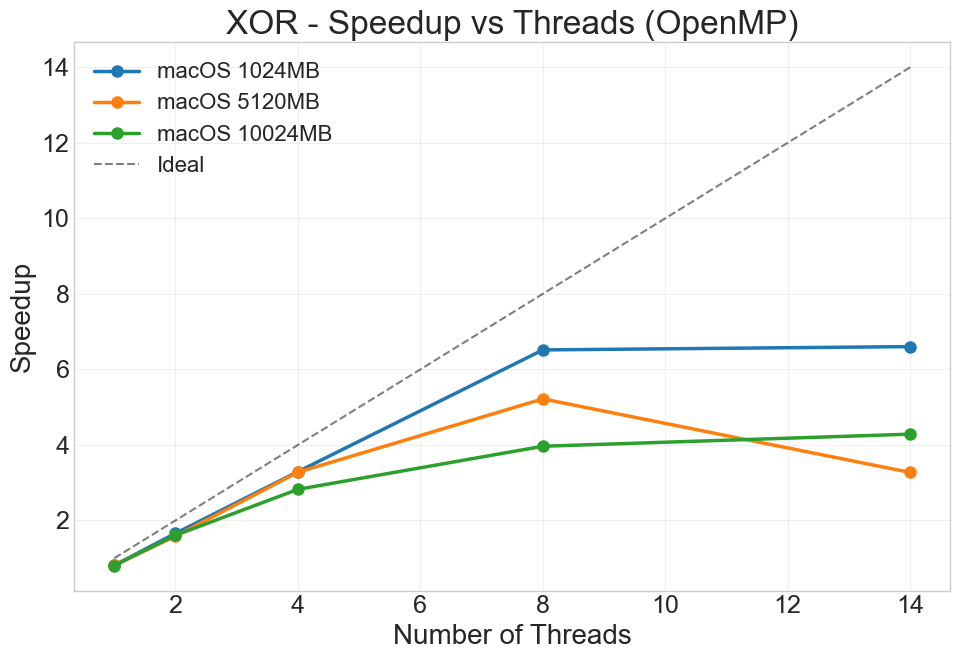

Saved: speedup_xor.png


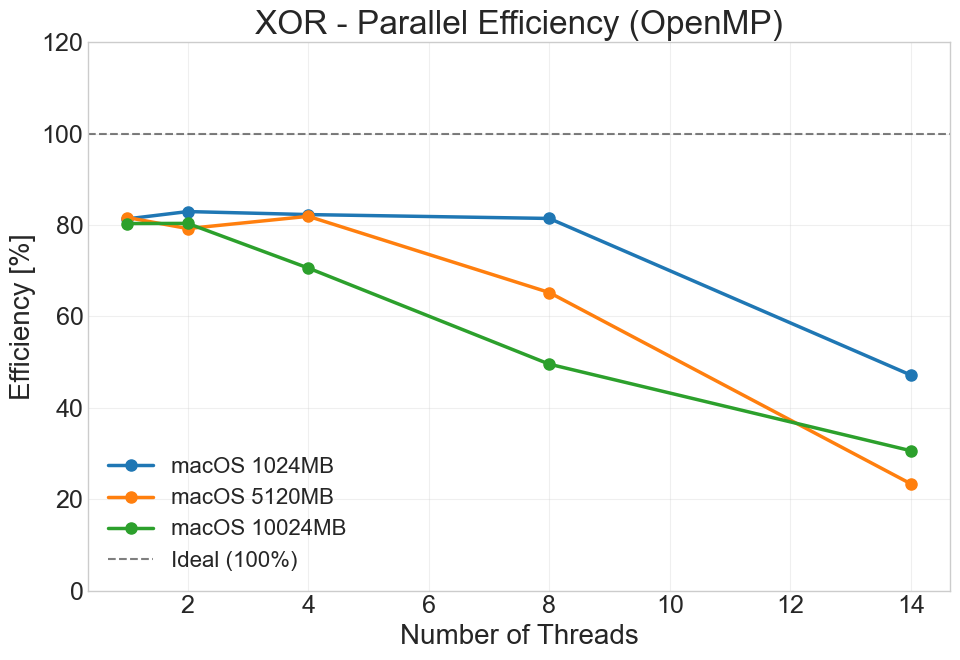

Saved: efficiency_xor.png


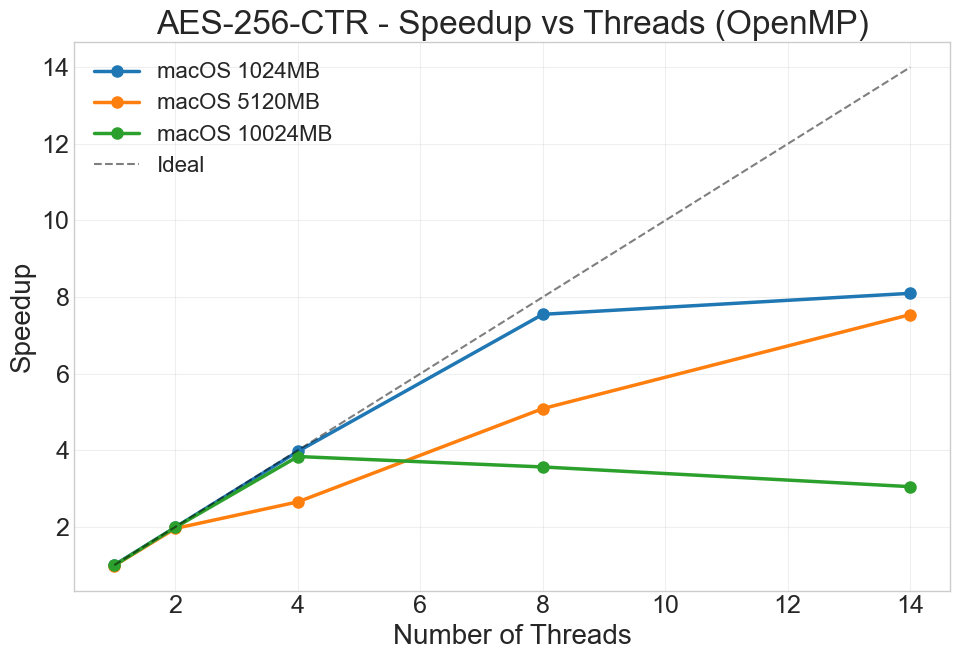

Saved: speedup_aes_256_ctr.png


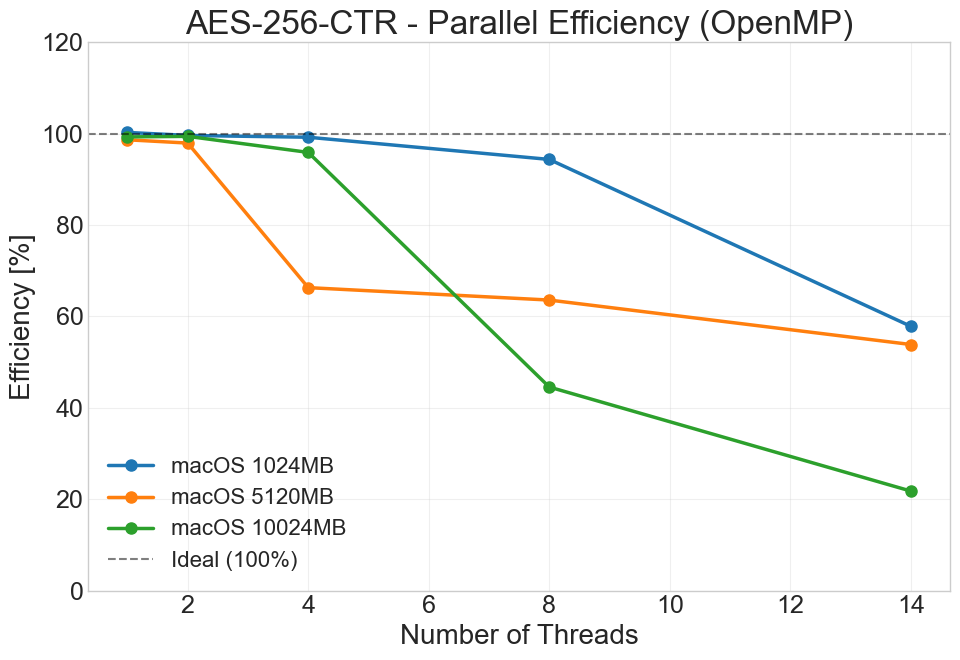

Saved: efficiency_aes_256_ctr.png


In [65]:
if 'df' in locals():
    output_dir = "../results/images"
    os.makedirs(output_dir, exist_ok=True)
    plot_speedup_efficiency(df, output_dir)

else:    print("Data not loaded.")

## Run All Plots

Generate all charts at once.

Generating all charts (individual plots)...


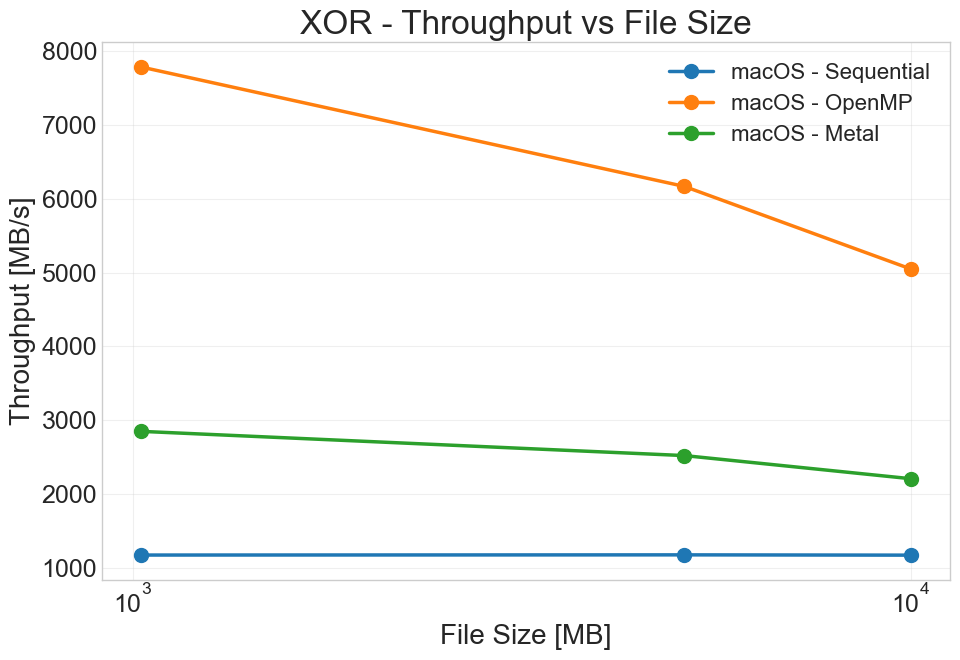

Saved: throughput_vs_filesize_xor.png


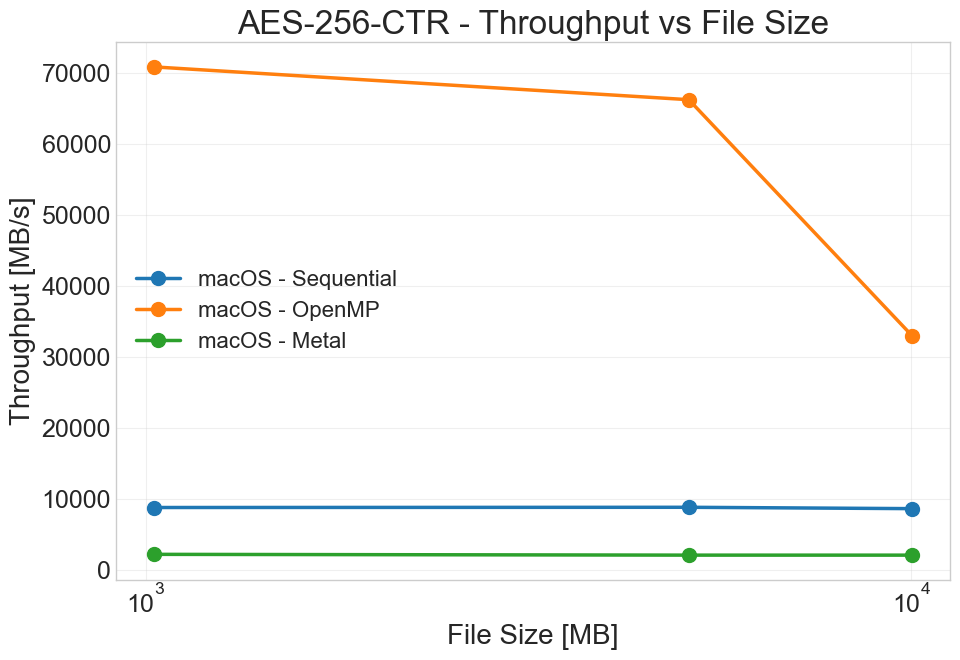

Saved: throughput_vs_filesize_aes_256_ctr.png


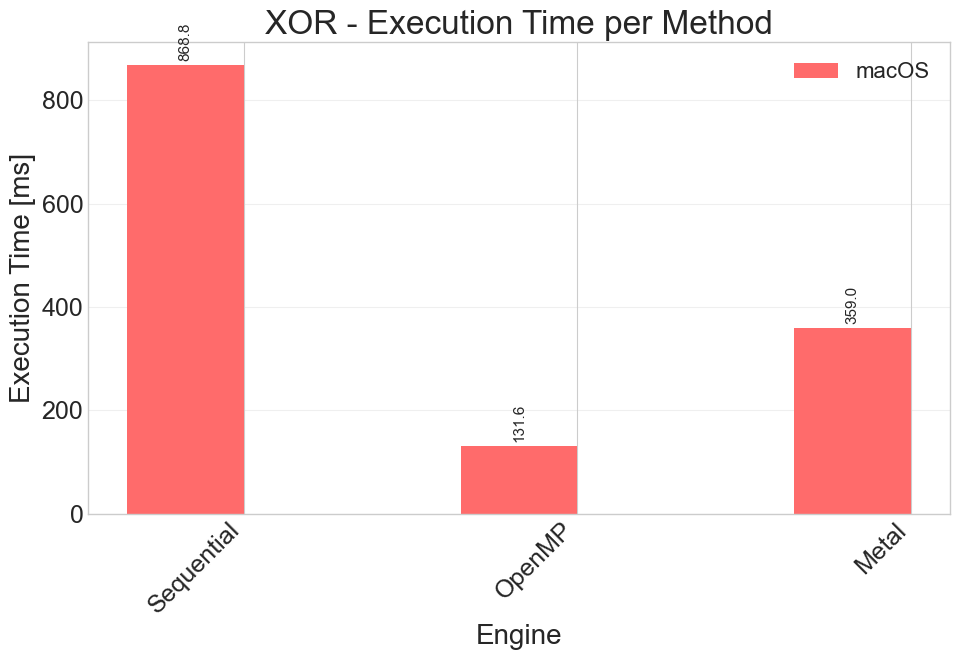

Saved: execution_time_xor.png


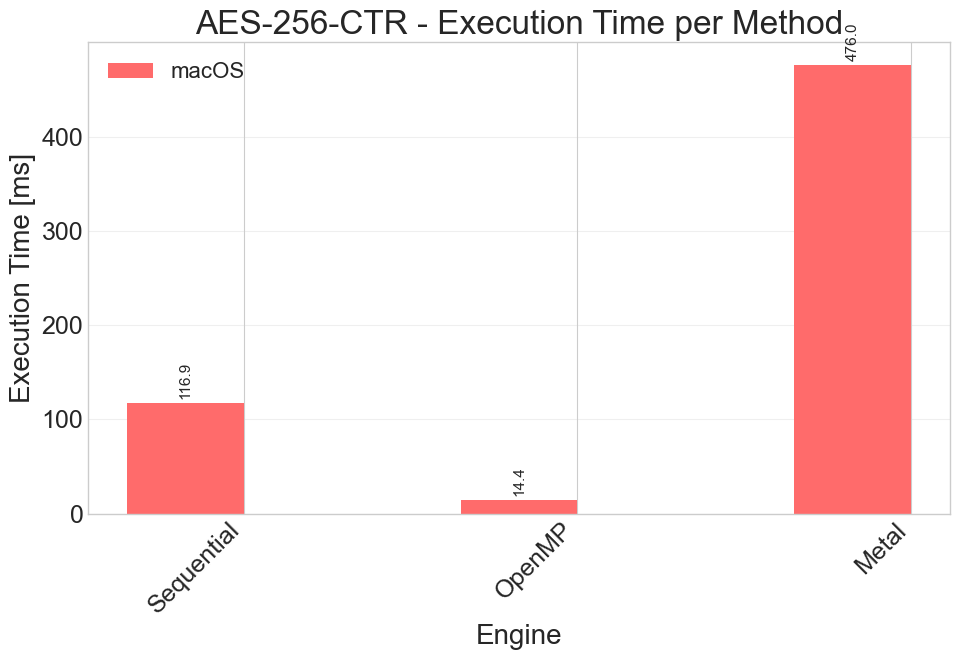

Saved: execution_time_aes_256_ctr.png


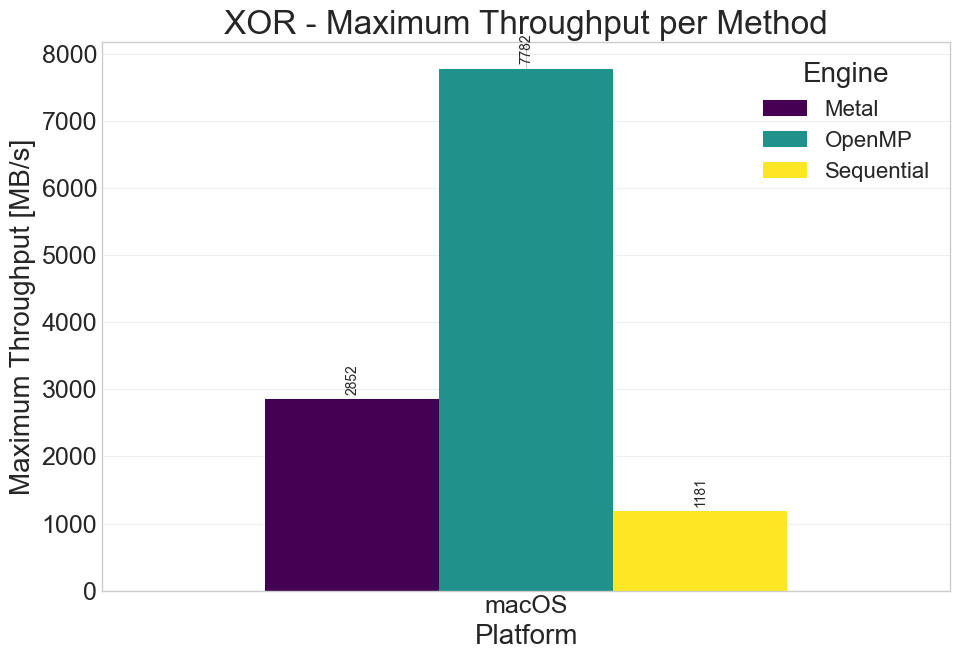

Saved: max_throughput_xor.png


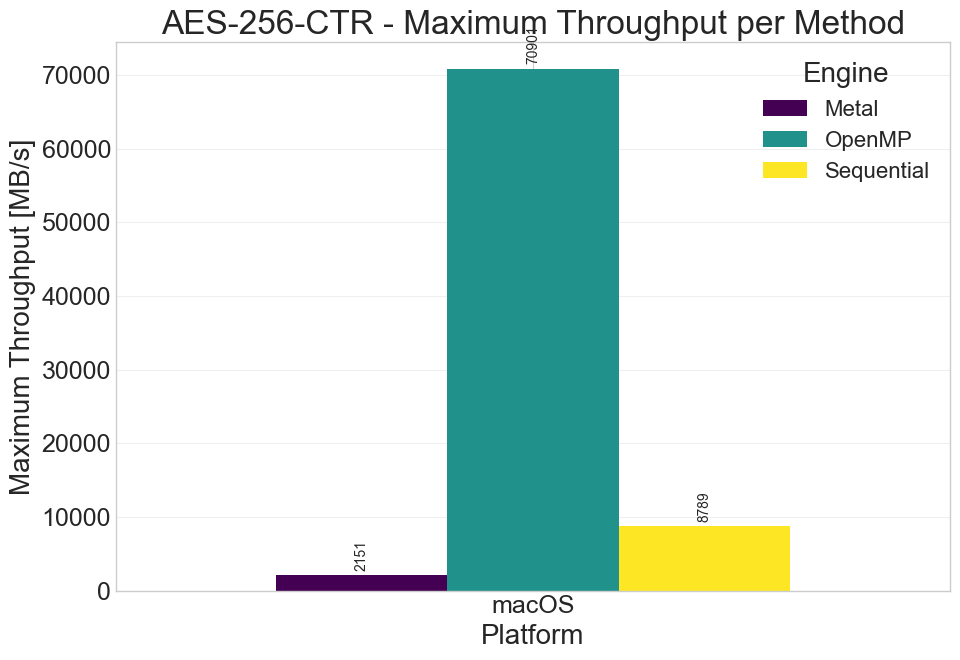

Saved: max_throughput_aes_256_ctr.png


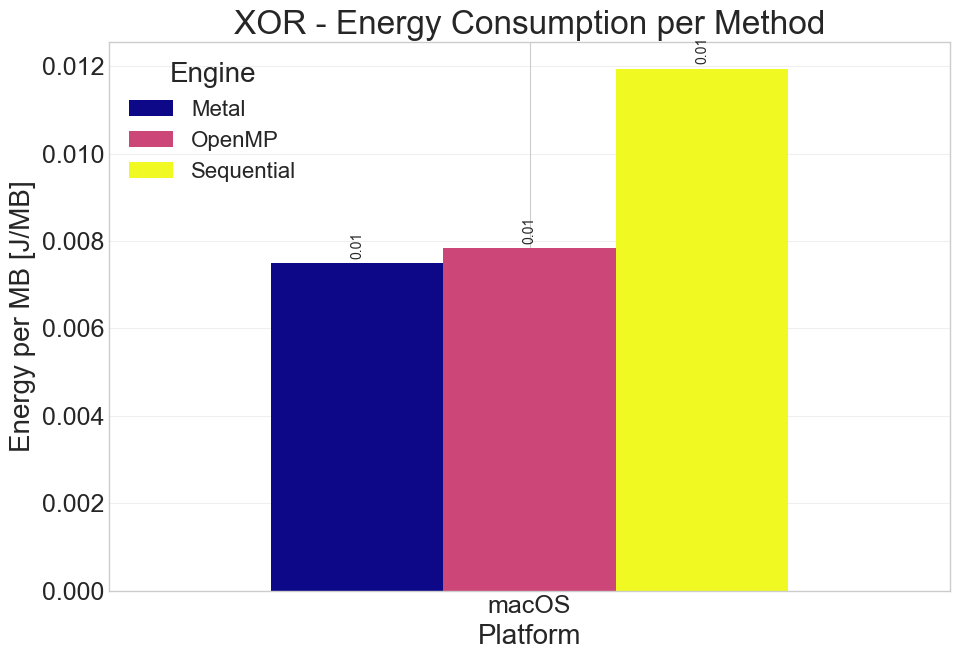

Saved: energy_consumption_xor.png


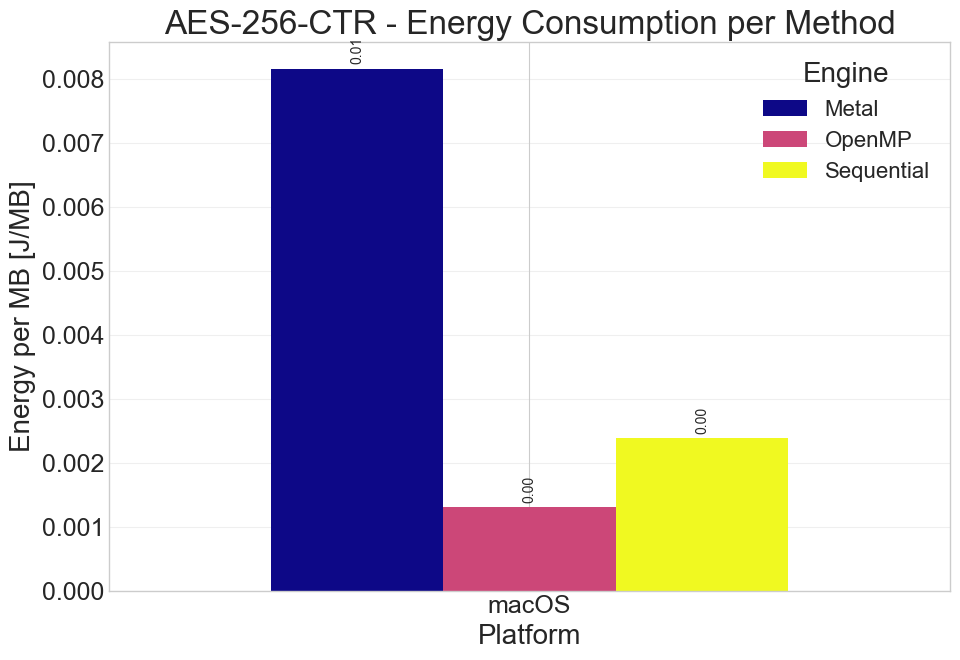

Saved: energy_consumption_aes_256_ctr.png


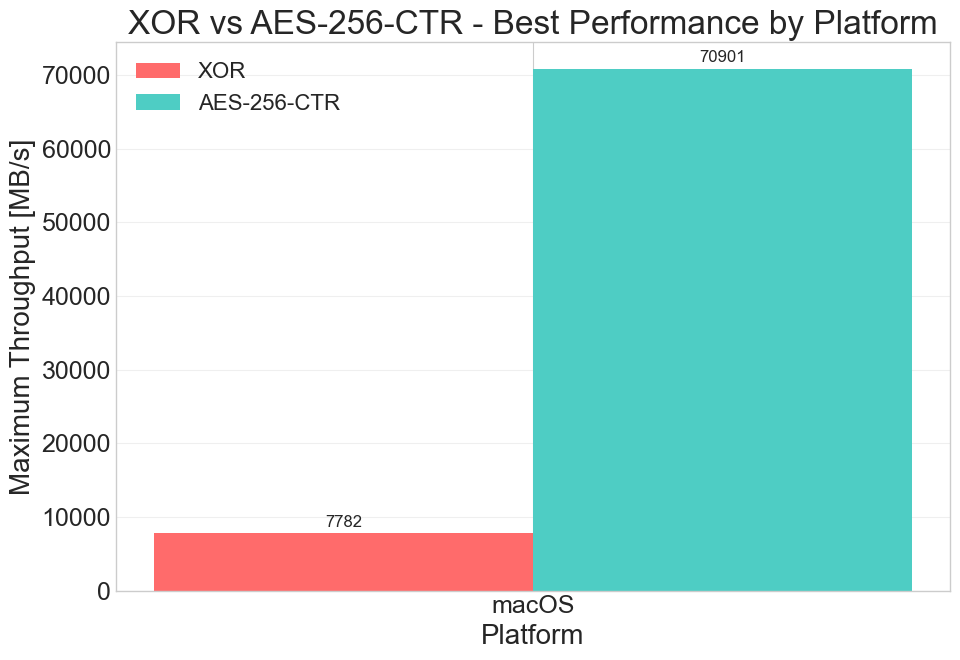

Saved: xor_vs_aes_comparison.png


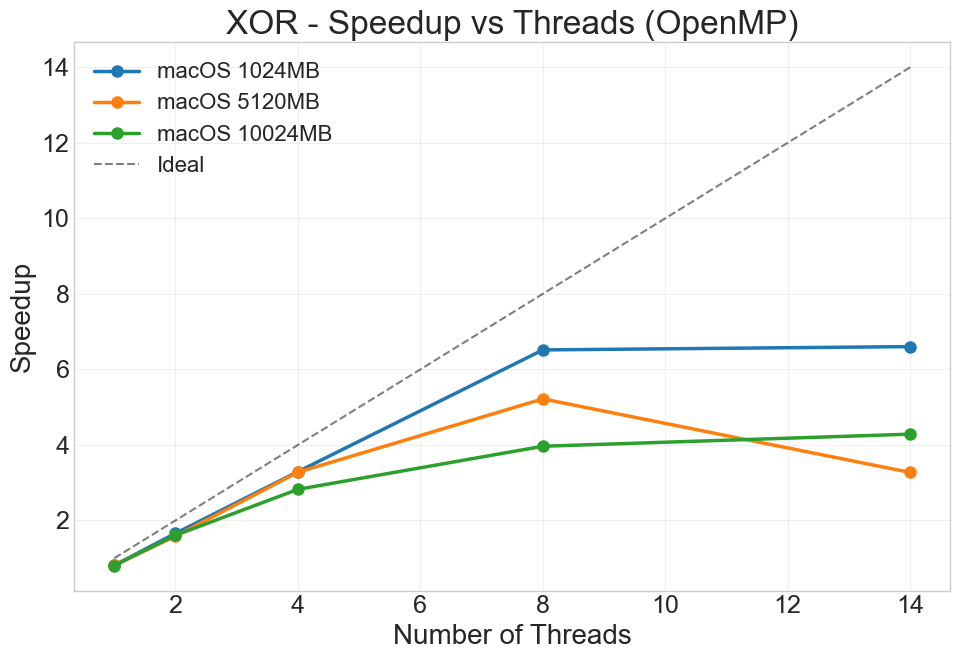

Saved: speedup_xor.png


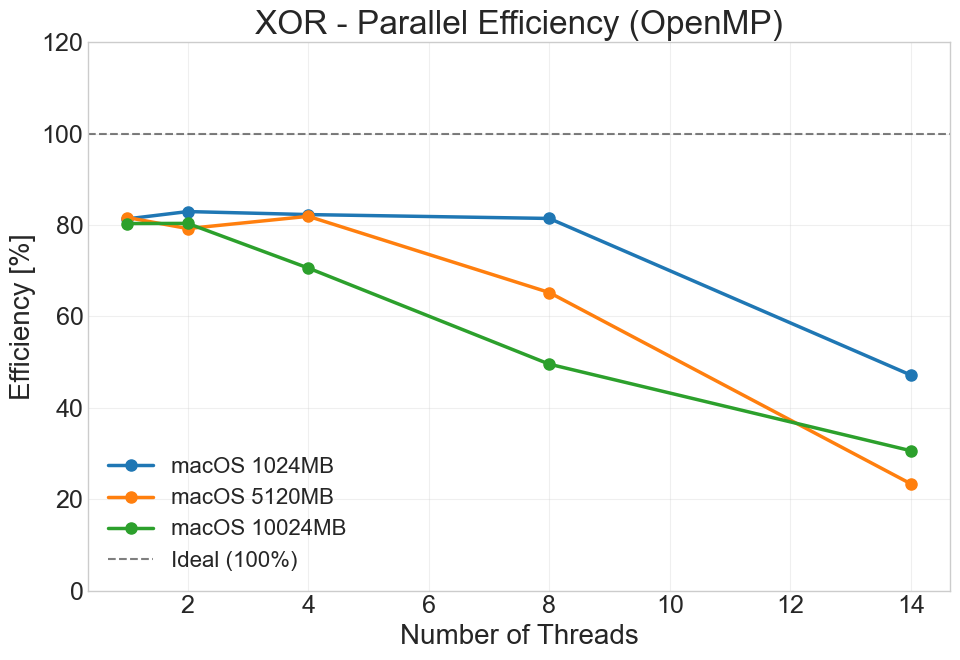

Saved: efficiency_xor.png


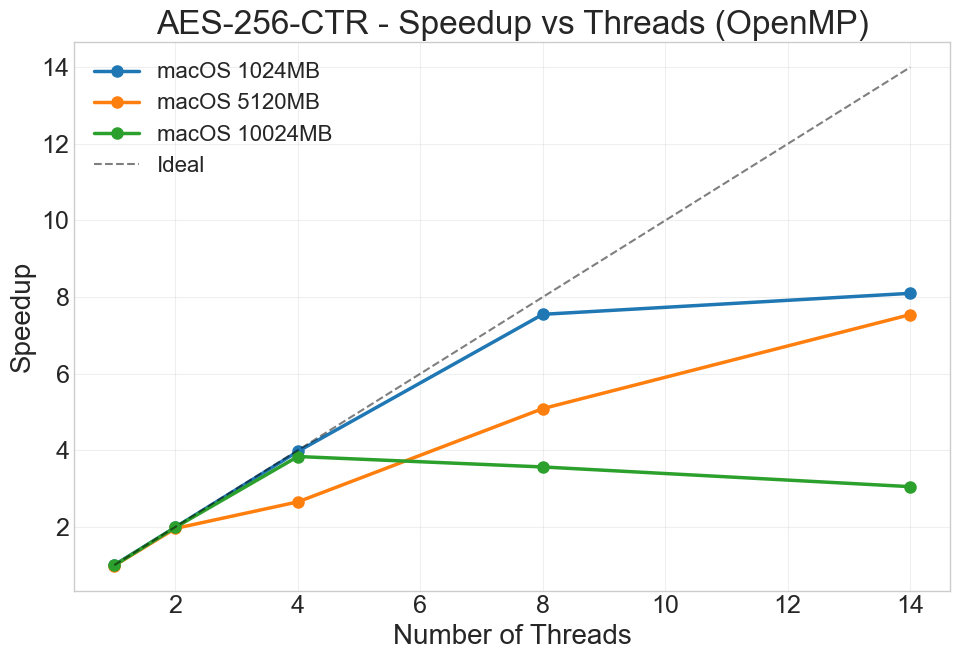

Saved: speedup_aes_256_ctr.png


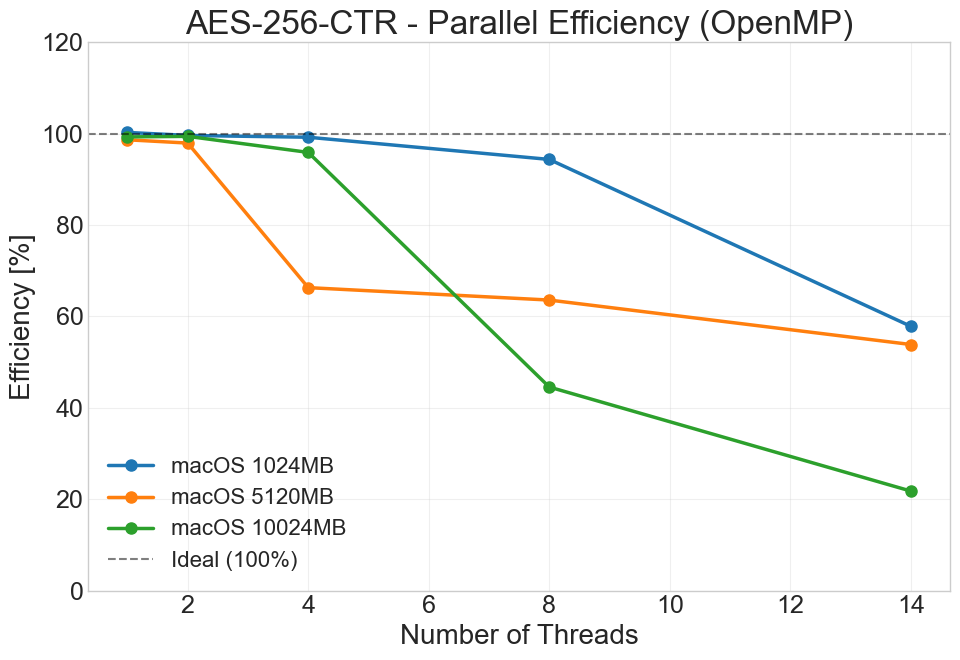

Saved: efficiency_aes_256_ctr.png

All charts saved to: ../results/images/


In [66]:
if 'df' in locals():
    print("Generating all charts (individual plots)...")
    output_dir = "../results/images"
    os.makedirs(output_dir, exist_ok=True)
    
    plot_throughput_vs_filesize(df, output_dir)
    plot_execution_time_comparison(df, output_dir)
    plot_max_throughput_per_method(df, output_dir)
    plot_energy_consumption(df, output_dir)
    plot_xor_vs_aes(df, output_dir)
    plot_speedup_efficiency(df, output_dir)
    print(f"\nAll charts saved to: {output_dir}/")
else:
    print("Data not loaded.")